# Get word embeddings using Word2Vec

Credits: https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92#702d

In [1]:
import pandas as pd
import numpy as np
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
#pip install --upgrade gensim
from gensim.models import Word2Vec

In [3]:
df = pd.DataFrame(pd.read_pickle('df_tokenized'))
#target
y=pd.cut(df.Rank,bins=[0,50,100],labels=[1,0])
#features
df=df['tokens']

In [4]:
## split dataset
X_train, X_test, y_train, y_test = train_test_split(df,y, test_size=0.33, random_state=42)

In [5]:
#preprocessing - gensim requires list of list representation

token_list=[]
for r in X_train:
    token_list.append(r)

    

In [6]:
#train gensim word2vec model
model = Word2Vec(token_list,vector_size=300,window=8, min_count=1, sg=1)

In [7]:
print("size of word vector: ", len(model.wv['love']))

size of word vector:  300


In [8]:
model.wv.similarity('love', 'like')

0.27932262

In [9]:
model.wv.similarity('love', 'hate')

0.3359967

In [10]:
model.wv.most_similar('love')

[('numbness', 0.6953150629997253),
 ('youthful', 0.6672893762588501),
 ('sensitive', 0.652812659740448),
 ('unfurl', 0.6463536620140076),
 ('satisfy', 0.6426259279251099),
 ('forsake', 0.6425955891609192),
 ('denied', 0.6420348286628723),
 ('yearning', 0.6397879719734192),
 ('willi', 0.6392258405685425),
 ('indefinitely', 0.6388156414031982)]

In [11]:
#set of all tokens
tokens=[]
for r in X_train:
    for token in r:
        tokens.append(token)
set_tokens=set(tokens)
len(set_tokens)

13674

In [12]:
#cosine similarity
from numpy.linalg import norm
def cosine_distance (model, word,target_list , num) :
    cosine_dict ={}
    word_list = []
    a = model.wv[word]
    for item in target_list :
        if item != word :
            b = model.wv[item]
            cos_sim = np.dot(a, b)/(norm(a)*norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in Descending order 
    for item in dist_sort:
        word_list.append((item[0], item[1]))
    return word_list[0:num]

In [13]:
cosine_distance(model,'love',set_tokens,5)

[('numbness', 0.6953151),
 ('youthful', 0.66728956),
 ('sensitive', 0.6528127),
 ('unfurl', 0.64635366),
 ('satisfy', 0.64262587)]

## Embedding matrix

The embedding matrix has the following dimensions: number of columns equal to the number of the embedding dimension (here:300) x number of unique words. Matrix of word embeddings will be used as a weight matrix in the neural network classifier.

In [14]:
#use word vectors as features
def get_word_vectors(model, set_tokens):
    wv=[]
    for token in set_tokens:
        wv.append(model.wv[token])

    wv=pd.DataFrame(wv, index=list(set_tokens))
    
    return wv
        
df_wv=get_word_vectors(model,set_tokens)


In [15]:
df_wv.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
gorilla,-0.079145,-0.006193,0.072533,0.061944,-0.006724,0.039238,0.060873,0.031630,0.063465,0.034930,...,0.048728,-0.009899,0.110652,-0.086736,0.007542,0.188761,-0.045126,-0.116713,0.071256,-0.064653
lockdown,-0.100143,0.259577,0.422064,-0.073646,-0.067288,0.056489,0.468386,0.417156,0.357477,-0.136470,...,0.119063,-0.336611,0.419891,-0.530535,-0.119969,0.238450,0.000516,-0.544624,0.232406,-0.266920
standard,-0.052428,-0.028799,0.035574,0.025988,-0.003427,-0.016190,0.050500,0.018597,0.064133,0.050584,...,0.019105,-0.029032,0.115665,-0.119825,-0.000891,0.152671,-0.039994,-0.096684,0.063665,-0.011112
gold,0.282676,-0.190009,0.126973,0.099592,0.170017,0.089717,0.051359,-0.045861,0.359999,-0.234365,...,0.139223,0.343076,0.171347,0.109004,0.049129,0.401316,-0.191278,-0.178892,0.184695,-0.298777
lobby,-0.106667,-0.044726,0.088510,0.079639,-0.012891,0.029740,0.085457,-0.015100,0.092464,0.079139,...,0.035695,-0.005415,0.080780,-0.093076,-0.015079,0.191705,-0.035350,-0.099658,0.052705,-0.057715


In [16]:
df_wv.shape

(13674, 300)

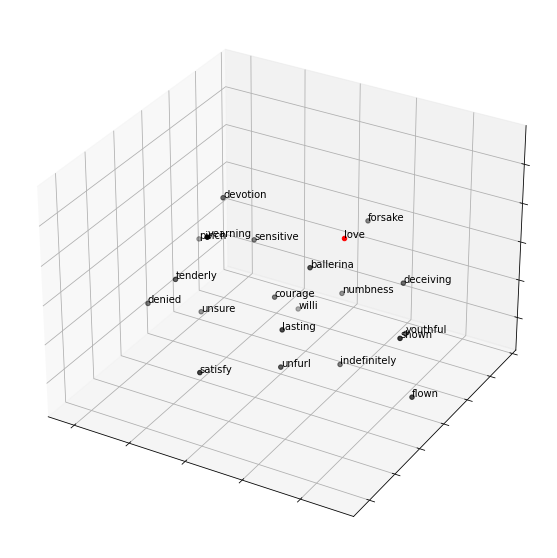

In [17]:
#plot word embeddings 

import warnings
warnings.filterwarnings('ignore')
word = "love"
fig = plt.figure(figsize=[10,10])
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 model.wv.most_similar(word, topn=20)]
X =  model.wv[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

## Neural Network using word embeddings

Credits: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

In [18]:
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [19]:
embeddings=df_wv
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      4102200     input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 15)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 15)      240         permute[0][0]                    
______________________________________________________________________________________________